In [37]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [38]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [39]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [40]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [41]:
#INFO: calling AutomapBase.prepare() while passing along the AutomapBase.prepare.reflect parameter indicates that the MetaData.reflect() method will be called on this declarative base classes’ MetaData collection; then, each viable Table within the MetaData will get a new mapped class generated automatically. The ForeignKeyConstraint objects which link the various tables together will be used to produce new, bidirectional relationship() objects between classes. The classes and relationships follow along a default naming scheme that we can customize. At this point, our basic mapping consisting of related User and Address classes is ready to use in the traditional way.
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [42]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [43]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [44]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [45]:
#how can I see if there is even data in there lol..... session.query(func.count("tbl"."colm").all() (if no .all it wont show)
session.query(func.count(measurement.date)).all()

# Find the most recent date in the data set. MY OTE: desc so decending order to get latest
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23')

In [46]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [47]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [52]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 2017-08-23 per above.
# Calculate the date one year from the last date in data set. 2016-08-23, 1 year prior to the above listed date
# Perform a query to retrieve the data and precipitation scores
precipitations = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > "2016-08-22").filter(Measurement.date < "2017-08-24").all()
#print(precipitations)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data = pd.DataFrame(precipitations).set_index('date')

# Sort the dataframe by date
precipitation_data = precipitation_data.sort_values(by='date')
precipitation_data.head()
# I see NaN values - lets delete null values shall we
precipitation_data = precipitation_data.sort_values(by='date').dropna()
precipitation_data.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


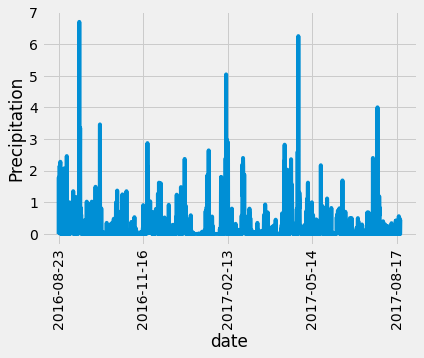

In [64]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_data.plot(rot=90, legend=False)
#plt.tight_layout()
plt.ylabel("Precipitation")
plt.show()

In [61]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [48]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [69]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.id, func.count(Station.id)).group_by(Station.id).all()
station_counts = session.query(Station.id).count()
print(station_count)
print(station_counts)

[(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]
9


In [72]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [75]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature. tobs?
station_min = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
station_max = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
station_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

In [80]:
print(f"Station 'USC00519281's lowest temperature is {station_min}")
print(f"Station 'USC00519281's highest temperature is {station_max}")
print(f"Station 'USC00519281's average temperature is {station_avg}")

Station 'USC00519281's lowest temperature is [(54.0,)]
Station 'USC00519281's highest temperature is [(85.0,)]
Station 'USC00519281's average temperature is [(71.66378066378067,)]


In [81]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram with bins=12
temp_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > "2016-08-22").filter(Measurement.station=='USC00519281').all()
#print(precipitations)

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_data_df = pd.DataFrame(temp_data).set_index('date')

temp_data_df.head()

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


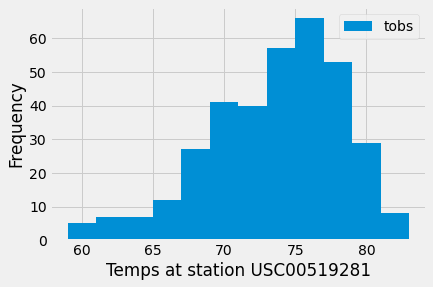

In [85]:
temp_data_df.plot.hist(bins = 12)
plt.xlabel("Temps at station USC00519281")
plt.show()

# Close session

In [86]:
# Close Session
session.close()

Step 2 - Climate App
Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.

Use Flask to create your routes.

Routes
/
Home page.
List all routes that are available.
/api/v1.0/precipitation

Convert the query results to a dictionary using date as the key and prcp as the value.
Return the JSON representation of your dictionary.
/api/v1.0/stations

Return a JSON list of stations from the dataset.
/api/v1.0/tobs

Query the dates and temperature observations of the most active station for the last year of data.
Return a JSON list of temperature observations (TOBS) for the previous year.
/api/v1.0/<start> and /api/v1.0/<start>/<end>

Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.

When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.

When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.

Hints
You will need to join the station and measurement tables for some of the queries.
Use Flask jsonify to convert your API data into a valid JSON response object.